In [6]:
import pandas as pd
from core.repository import load_financial
from base.timeutil import YearMonth
import sqlite3
from core.repository.maria.conn import maria_home

db_file = "analysis.db"

try:
    layer1 = pd.read_sql("select * from layer1", sqlite3.connect(db_file))
except:
    month_chart = pd.read_sql("""
    select month_chart.*, stock.name, stock.exchange
    from month_chart
    join stock on substring(month_chart.code, -6) = stock.code;
    """, maria_home())
    month_chart["code"] = month_chart["code"].apply(lambda code: code[-6:])

    begin = YearMonth(2002, 6)
    end = YearMonth(2023, 1)

    month_chart["년월"] = [YearMonth.from_date(d) for d in month_chart["date"]]
    layer1 = pd.DataFrame()
    for ym1, ym2 in [(row.iloc[0], row.iloc[1]) for row in pd.Series(begin.to(end)).rolling(2) if len(row) == 2]:
        print(f"\r{ym1} {ym2}", end="\r")
        df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
        # 당일 1000만원 이상 거래 발생 종목만 취급
        df1 = df1[df1["cap"] != 0]
        df1 = df1[df1["vol"] * df1["close"] > 1_000_0000]
        df1 = df1[df1["vol_lastday"] * df1["close"] > 1_000_0000]
        df2 = month_chart[month_chart["년월"] == ym2].set_index("code")

        df = pd.DataFrame({
            "종목명": df1["name"],
            "거래소": df1["exchange"],
            "매수년월": str(ym1),
            "매도년월": str(ym2),
            "시가총액": df1["cap"],
            "매수일": df1["date"],
            "매수가": df1["close"],
            "거래량": df1["vol"],
        })

        df["매도가"] = df2["close"]
        df["매도일"] = df2["date"]
        df["수익률"] = df["매도가"] / df["매수가"] - 1

        # 재무데이터 조인하여 layer1에 반영
        fn = load_financial(ym1.year, ym1.month)
        layer1 = pd.concat([layer1, df.join(fn)])

    layer1 = layer1.reset_index()
    layer1["확정실적"] = str(layer1["확정실적"])
    layer1.to_sql("layer1", sqlite3.connect(db_file), if_exists="replace", index=False)

layer1

,code,종목명,거래소,매수년월,매도년월,시가총액,매수일,매수가,거래량,매도가,...,매출총이익,영업이익,당기순이익,GP_YoY,O_YoY,E_YoY,GP_QoQ,O_QoQ,E_QoQ,확정실적
0,054540,삼영엠텍,KOSDAQ,2002-06,2002-07,9124000000,2002-06-28,790,3670247,705.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.686191,-0.884665,-0.988888,0 2002-1Q\n1 2002-1Q\n2 ...
1,003960,사조대림,KOSPI,2002-06,2002-07,7682000000,2002-06-28,34452,36811,33208.0,...,6.092276e+10,3.302530e+10,1.713621e+10,1.261899,18.475645,1.501227,0.372800,2.120146,1.001826,0 2002-1Q\n1 2002-1Q\n2 ...
2,019570,리더스 기술투자,KOSDAQ,2002-06,2002-07,1560000000,2002-06-28,2811,49172,2436.0,...,NaN,2.829819e+09,NaN,NaN,1.153040,NaN,NaN,1.885100,NaN,0 2002-1Q\n1 2002-1Q\n2 ...
3,056080,유진로봇,KOSDAQ,2002-06,2002-07,25496000000,2002-06-28,3953,735680,3705.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.662111,-0.883125,-0.843128,0 2002-1Q\n1 2002-1Q\n2 ...
4,007330,푸른저축은행,KOSDAQ,2002-06,2002-07,56375000000,2002-06-28,4100,432748,4000.0,...,NaN,3.142194e+10,NaN,NaN,NaN,NaN,NaN,5.609433,9.759201,0 2002-1Q\n1 2002-1Q\n2 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378209,005820,원림,KOSPI,2022-12,2023-01,47203000000,2022-12-29,20550,127807,21900.0,...,1.822819e+10,6.343297e+09,8.337534e+09,0.293697,1.953730,2.704558,-0.130430,-0.441156,-0.050023,0 2002-1Q\n1 2002-1Q\n2 ...
378210,064240,홈캐스트,KOSDAQ,2022-12,2023-01,154867000000,2022-12-29,4420,2695198,4275.0,...,1.406016e+09,-3.395800e+07,2.246459e+10,-0.867293,0.992812,11.474319,-0.523084,0.885062,-0.574004,0 2002-1Q\n1 2002-1Q\n2 ...
378211,293480,하나제약,KOSPI,2022-12,2023-01,324339000000,2022-12-29,18250,6246490,15660.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.063546,-0.330023,-0.229548,0 2002-1Q\n1 2002-1Q\n2 ...
378212,009580,무림P&P,KOSPI,2022-12,2023-01,271300000000,2022-12-29,4350,4416337,4220.0,...,1.273513e+11,6.570994e+10,3.820643e+10,0.930121,3.778405,8.382159,1.420173,3.015172,3.602178,0 2002-1Q\n1 2002-1Q\n2 ...


In [7]:

import numpy as np

layer2 = layer1.rename(
    columns={
        "시가총액": "P",
        "자산총계": "A",
        "자본총계": "EQ",

        "매출총이익": "GP",
        "영업이익": "O",
        "당기순이익": "E",
    }
)

factors = ["GP_YoY", "GP_QoQ", "O_YoY", "O_QoQ"]

for pos in ["A", "EQ"]:
    factor = f"{pos}/P"
    factors.append(factor)
    layer2[factor] = layer2[pos] / layer2["P"]
    layer2.loc[layer2[pos] <= 0, factor] = np.nan

for neg in ["P", "A", "EQ"]:
    for pos in ["GP", "O", "E"]:
        factor = f"{pos}/{neg}"
        factors.append(factor)
        layer2[factor] = layer2[pos] / layer2[neg]
        layer2.loc[layer2[neg] <= 0, factor] = np.nan

factors.append("P")

result = pd.DataFrame()
yms = layer2["매수년월"].unique()

earning_factor_weights = {
    "GP_QoQ": 2,
    "O_QoQ": 2,
    "GP_YoY": 1,
    "O_YoY": 1
}

recipes = []
for gppw in [4, 5, 6, 8]:
    for pw in [-6, -8, -10, -12]:
        recipes.append({"GP/P": gppw, "P": pw, **earning_factor_weights})

# 위 코드는 향후 recipe 생성 과정에서 사용할 것

from core.strategy import recipe

recipes = [recipe, recipe]

print(pd.DataFrame(recipes))

for ym in yms:
    df = layer2[layer2["매수년월"] == ym].copy()
    for factor in factors:
        print(f"\r{ym}", end="")
        colname_pct = f"{factor}_pct"
        df[colname_pct] = np.ceil(df[factor].rank(method="min", pct=True) * 100)

    for i in range(len(recipes)):
        factor = f"super{i}"
        # 1. 레시피를 구성하는 개별 팩터 분위(percentile) * 가중치의 총합을 구함
        sv = sum([df[f"{k}_pct"] * w if w > 0 else (1 - df[f"{k}_pct"]) * abs(w) for k, w in recipe.items()])
        # 2. 위의 시리즈에 가중치의 총합을 나눈다 => 0~1 사이 값으로 일반화됨
        df[factor] = sv / sum([abs(w) for w in recipe.values()])
        df[f"{factor}_pct"] = np.ceil(df[factor].rank(method="min", pct=True) * 100)

    result = pd.concat([result, df])

factors = [f"super{i}" for i in range(len(recipes))] + factors
result

   GP/P  P  GP_YoY  GP_QoQ  O_YoY  O_QoQ
0     8 -8       1       2      1      2
1     8 -8       1       2      1      2
2022-12

,code,종목명,거래소,매수년월,매도년월,P,매수일,매수가,거래량,매도가,...,O/A_pct,E/A_pct,GP/EQ_pct,O/EQ_pct,E/EQ_pct,P_pct,super0,super0_pct,super1,super1_pct
0,054540,삼영엠텍,KOSDAQ,2002-06,2002-07,9124000000,2002-06-28,790,3670247,705.0,...,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN
1,003960,사조대림,KOSPI,2002-06,2002-07,7682000000,2002-06-28,34452,36811,33208.0,...,78.0,65.0,96.0,98.0,97.0,9.0,57.545455,100.0,57.545455,100.0
2,019570,리더스 기술투자,KOSDAQ,2002-06,2002-07,1560000000,2002-06-28,2811,49172,2436.0,...,57.0,NaN,NaN,45.0,NaN,2.0,NaN,NaN,NaN,NaN
3,056080,유진로봇,KOSDAQ,2002-06,2002-07,25496000000,2002-06-28,3953,735680,3705.0,...,NaN,NaN,NaN,NaN,NaN,44.0,NaN,NaN,NaN,NaN
4,007330,푸른저축은행,KOSDAQ,2002-06,2002-07,56375000000,2002-06-28,4100,432748,4000.0,...,53.0,NaN,NaN,98.0,NaN,71.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378209,005820,원림,KOSPI,2022-12,2023-01,47203000000,2022-12-29,20550,127807,21900.0,...,56.0,65.0,23.0,44.0,53.0,15.0,31.363636,87.0,31.363636,87.0
378210,064240,홈캐스트,KOSDAQ,2022-12,2023-01,154867000000,2022-12-29,4420,2695198,4275.0,...,27.0,98.0,5.0,27.0,94.0,59.0,-7.590909,11.0,-7.590909,11.0
378211,293480,하나제약,KOSPI,2022-12,2023-01,324339000000,2022-12-29,18250,6246490,15660.0,...,NaN,NaN,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN
378212,009580,무림P&P,KOSPI,2022-12,2023-01,271300000000,2022-12-29,4350,4416337,4220.0,...,59.0,48.0,37.0,66.0,53.0,74.0,24.863636,75.0,24.863636,75.0


2/2
2002-06 2023-01
   GP/P  P  GP_YoY  GP_QoQ  O_YoY  O_QoQ
0     8 -8       1       2      1      2
1     8 -8       1       2      1      2


,spearman,top,h3,h5,h10,t5,h5-t5,h5-t5+mdd5,mean,median,mdd5
factor,,,,,,,,,,,
super0,0.95844,0.659024,0.582264,0.551306,0.485456,-0.062976,0.614282,0.10014,0.162101,0.146447,-0.514142
super1,0.95844,0.659024,0.582264,0.551306,0.485456,-0.062976,0.614282,0.10014,0.162101,0.146447,-0.514142


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

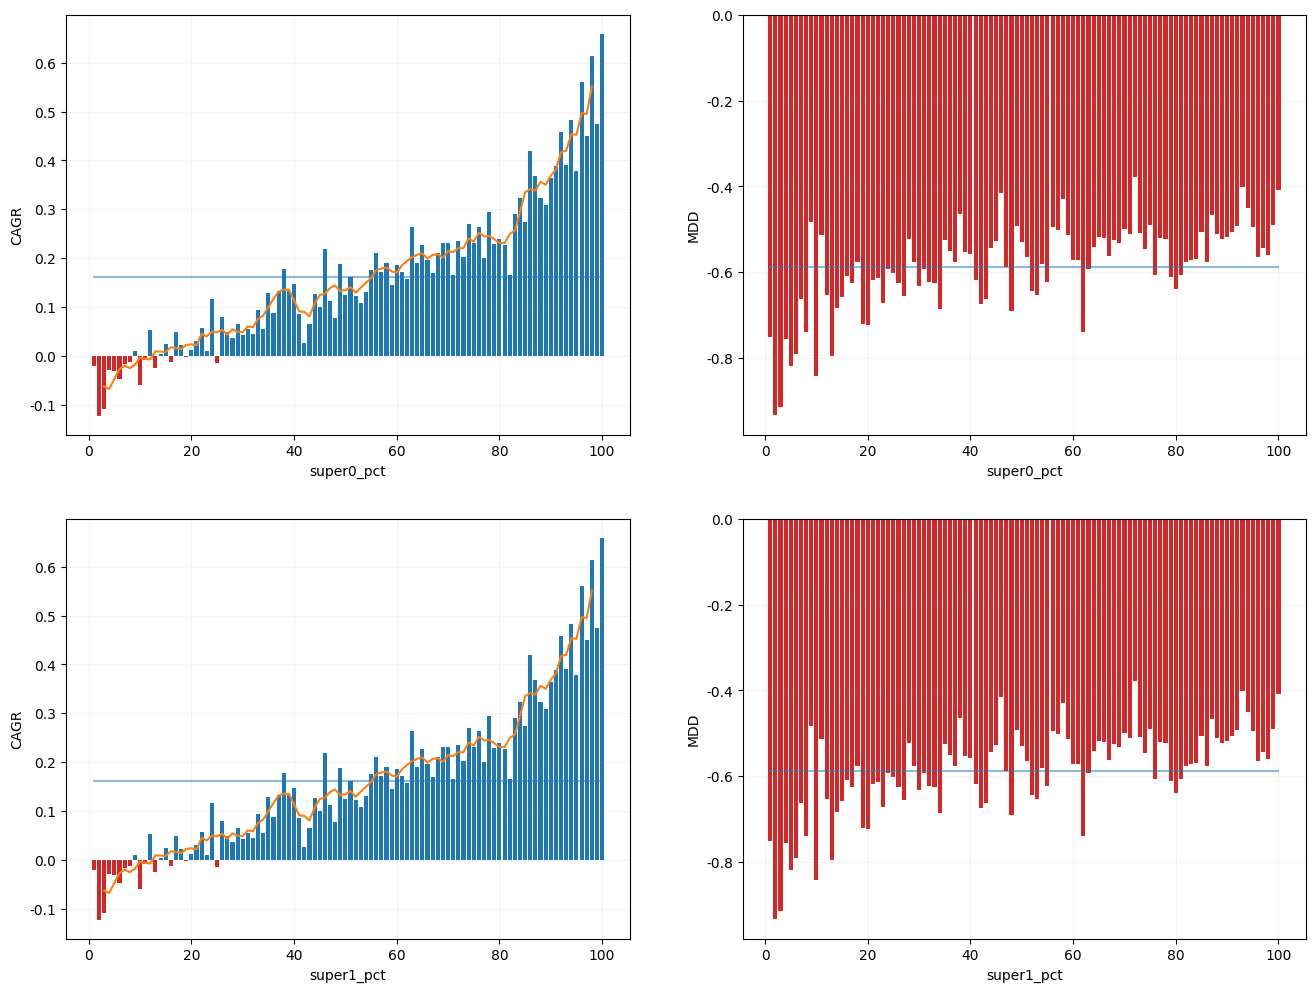

In [8]:
import matplotlib.pyplot as plt
from core.base.quantutil import cagr, mdd
from base.timeutil import YearMonth
from datetime import date

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10000

target_factors = [f for f in factors if f.startswith("super")]
fig, subplots = plt.subplots(len(target_factors), 2)
fig.set_figwidth(16), fig.set_figheight(6 * len(target_factors))

summary = pd.DataFrame()
for i in range(len(target_factors)):
    print(f"\r{i + 1}/{len(target_factors)}", end="")
    factor = factors[i]
    colname_pct = f"{factor}_pct"
    percentiles = sorted(set(result[colname_pct].dropna()))
    mean_by_pct = []
    cagr_by_pct = []
    mdd_by_pct = []
    for pct in percentiles:
        by_pct = result[result[colname_pct] == pct]
        return_by_ym = by_pct.groupby("매도년월")["수익률"].mean()
        begin = YearMonth.from_string(by_pct["매수년월"].min())
        cumprod = (return_by_ym + 1).cumprod()
        last = cumprod[-1]
        mean_by_pct.append(return_by_ym.mean())
        cagr_by_pct.append(cagr(1, last, by_pct["매도년월"].unique().size / 12))
        dates = [date(int(s.split("-")[0]), int(s.split("-")[1]), 1) for s in return_by_ym.index]
        mdd_by_pct.append(mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]

    cagr_by_pct_series = pd.Series(cagr_by_pct)
    mdd_by_pct_series = pd.Series(mdd_by_pct)

    ax1.set_xlabel(colname_pct)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(percentiles, cagr_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in cagr_by_pct])
    ax1.plot(percentiles, [cagr_by_pct_series.mean() for _ in percentiles], alpha=0.5)
    ax1.plot(percentiles, cagr_by_pct_series.rolling(5, center=True).mean())

    ax2.set_xlabel(colname_pct)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(percentiles, mdd_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in mdd_by_pct])
    ax2.plot(percentiles, [mdd_by_pct_series.mean() for _ in percentiles], alpha=0.5)

    corr = pd.DataFrame({colname_pct: percentiles, "cagr": cagr_by_pct}).corr(method="spearman")
    cagr_by_pct_desc = cagr_by_pct_series[cagr_by_pct_series.index.sort_values(ascending=False)]
    mdd_by_pct_desc = mdd_by_pct_series[mdd_by_pct_series.index.sort_values(ascending=False)]
    summary = pd.concat([
        summary,
        pd.Series({
            "spearman": corr[colname_pct]["cagr"],
            "top": cagr_by_pct_desc.head(1).mean(),
            "h3": cagr_by_pct_desc.head(3).mean(),
            "h5": cagr_by_pct_desc.head(5).mean(),
            "h10": cagr_by_pct_desc.head(10).mean(),
            "t5": cagr_by_pct_desc.tail(5).mean(),
            "h5-t5": cagr_by_pct_desc.head(5).mean() - cagr_by_pct_desc.tail(5).mean(),
            "h5-t5+mdd5": cagr_by_pct_desc.head(5).mean() - cagr_by_pct_desc.tail(
                5).mean() + mdd_by_pct_desc.head(5).mean(),
            "mean": cagr_by_pct_desc.mean(),
            "median": cagr_by_pct_desc.median(),
            "mdd5": mdd_by_pct_desc.head(5).mean(),
        }).to_frame(factor).T
    ])

print()
print(result["매수년월"].min(), result["매도년월"].max())
print(pd.DataFrame(recipes))

summary.index.name = "factor"
summary.to_sql("sfw", sqlite3.connect(db_file), if_exists="replace")
summary = summary.sort_values("h5", ascending=False)
summary

In [18]:
_key = ["매수년월", "매도년월"]
benchmark = result.groupby(_key)["수익률"].mean()

factor = "super0"
print(recipes[0])
head = 12
result2 = result[~result["종목명"].str.endswith("홀딩스")]
result2 = result2[~result2["종목명"].str.endswith("지주")]
# result2 = result2[result2["1/P"].rank(ascending=False, method="min", pct=True) < 0.3]

strategy = result2.groupby(_key).apply(
    lambda values: values.sort_values(factor, ascending=False).head(head)["수익률"].mean())
strategy = pd.Series(strategy, index=benchmark.index).fillna(0)
result2.groupby(_key).apply(lambda values: values.sort_values(factor, ascending=False).head(head))[
    ["code", "종목명", "수익률", "거래소", "매수일", "매도일", "매수가", "매도가", factor]]

{'GP/P': 8, 'P': -8, 'GP_YoY': 1, 'GP_QoQ': 2, 'O_YoY': 1, 'O_QoQ': 2}


code      종목명       수익률     거래소         매수일  \
매수년월    매도년월                                                            
2002-06 2002-07 504     006090     사조오양 -0.023342   KOSPI  2002-06-28   
                1       003960     사조대림 -0.036108   KOSPI  2002-06-28   
                451     017550    수산중공업 -0.165746   KOSPI  2002-06-28   
                515     033540      파라텍 -0.031746  KOSDAQ  2002-06-28   
                471     027740      마니커 -0.042055   KOSPI  2002-06-28   
...                        ...      ...       ...     ...         ...   
2022-12 2023-01 377471  054940    엑사이엔씨  0.144981  KOSDAQ  2022-12-29   
                377145  088790       진도  0.043643   KOSPI  2022-12-29   
                378028  004100     태양금속  0.112111   KOSPI  2022-12-29   
                377687  026040   제이에스티나  0.267748  KOSDAQ  2022-12-29   
                376107  122690  서진오토모티브  0.071956  KOSDAQ  2022-12-29   

                               매도일    매수가      매도가     super0  
매수년월    매도년월                                                   
2002-06 2002-07 504     2002-07-31   1885   1841.0  58.727273  
                1       2002-07-31  34452  33208.0  57.545455  
                451     2002-07-31    362    302.0  56.363636  
                515     2002-07-31     63     61.0  55.863636  
                471     2002-07-31   3329   3189.0  54.772727  
...                            ...    ...      ...        ...  
2022-12 2023-01 377471  2023-01-31   1345   1540.0  51.045455  
                377145  2023-01-31   2635   2750.0  50.909091  
                378028  2023-01-31   1445   1607.0  50.590909  
                377687  2023-01-31   2465   3125.0  50.409091  
                376107  2023-01-31   2710   2905.0  50.045455  

[2964 rows x 9 columns]

In [19]:
from core.base.quantutil import cagr, mdd
from base.timeutil import YearMonth

revisions = pd.DataFrame({
    "벤치마크 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": round(strategy - benchmark, 2),
    "벤치마크 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod()
})


def str_to_ym(_s: str):
    _sp = _s.split("-")
    return YearMonth(int(_sp[0]), int(_sp[1]))


begin = str_to_ym(revisions.index[0][0])
end = str_to_ym(revisions.index[-1][-1])
years = (end.value() - begin.value()) / 12

summary = pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"][-1], years), cagr(1, revisions["벤치마크 누적수익률"][-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions.index], revisions["전략 누적수익률"]),
            mdd([i2 for _, i2 in revisions.index], revisions["벤치마크 누적수익률"])],
    "Mean": [revisions["전략 수익률"].mean(), revisions["벤치마크 수익률"].mean()]
}, index=["전략", "벤치마크"])
print(summary)

revisions

          CAGR                                         MDD      Mean
전략    0.617533  (-0.41533703599960614, (2008-06, 2008-10))  0.046112
벤치마크  0.162415   (-0.5373813097521327, (2007-07, 2008-10))  0.014975


,,벤치마크 수익률,전략 수익률,성능,벤치마크 누적수익률,전략 누적수익률
매수년월,매도년월,,,,,
2002-06,2002-07,-0.002350,0.012092,0.01,0.997650,1.012092
2002-07,2002-08,0.034984,0.117881,0.08,1.032552,1.131399
2002-08,2002-09,-0.148973,-0.042996,0.11,0.878730,1.082753
2002-09,2002-10,0.045789,0.004445,-0.04,0.918966,1.087566
2002-10,2002-11,0.052203,0.025376,-0.03,0.966939,1.115164
...,...,...,...,...,...,...
2022-08,2022-09,-0.155583,-0.144817,0.01,19.476918,14751.512599
2022-09,2022-10,0.021808,0.108739,0.09,19.901671,16355.578947
2022-10,2022-11,0.081889,0.152116,0.07,21.531397,18843.527586


전체 개월 수      247.00
초과수익 개월 수    170.00
아웃퍼폼 총합        9.43
언더퍼폼 총합       -1.59
dtype: float64

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

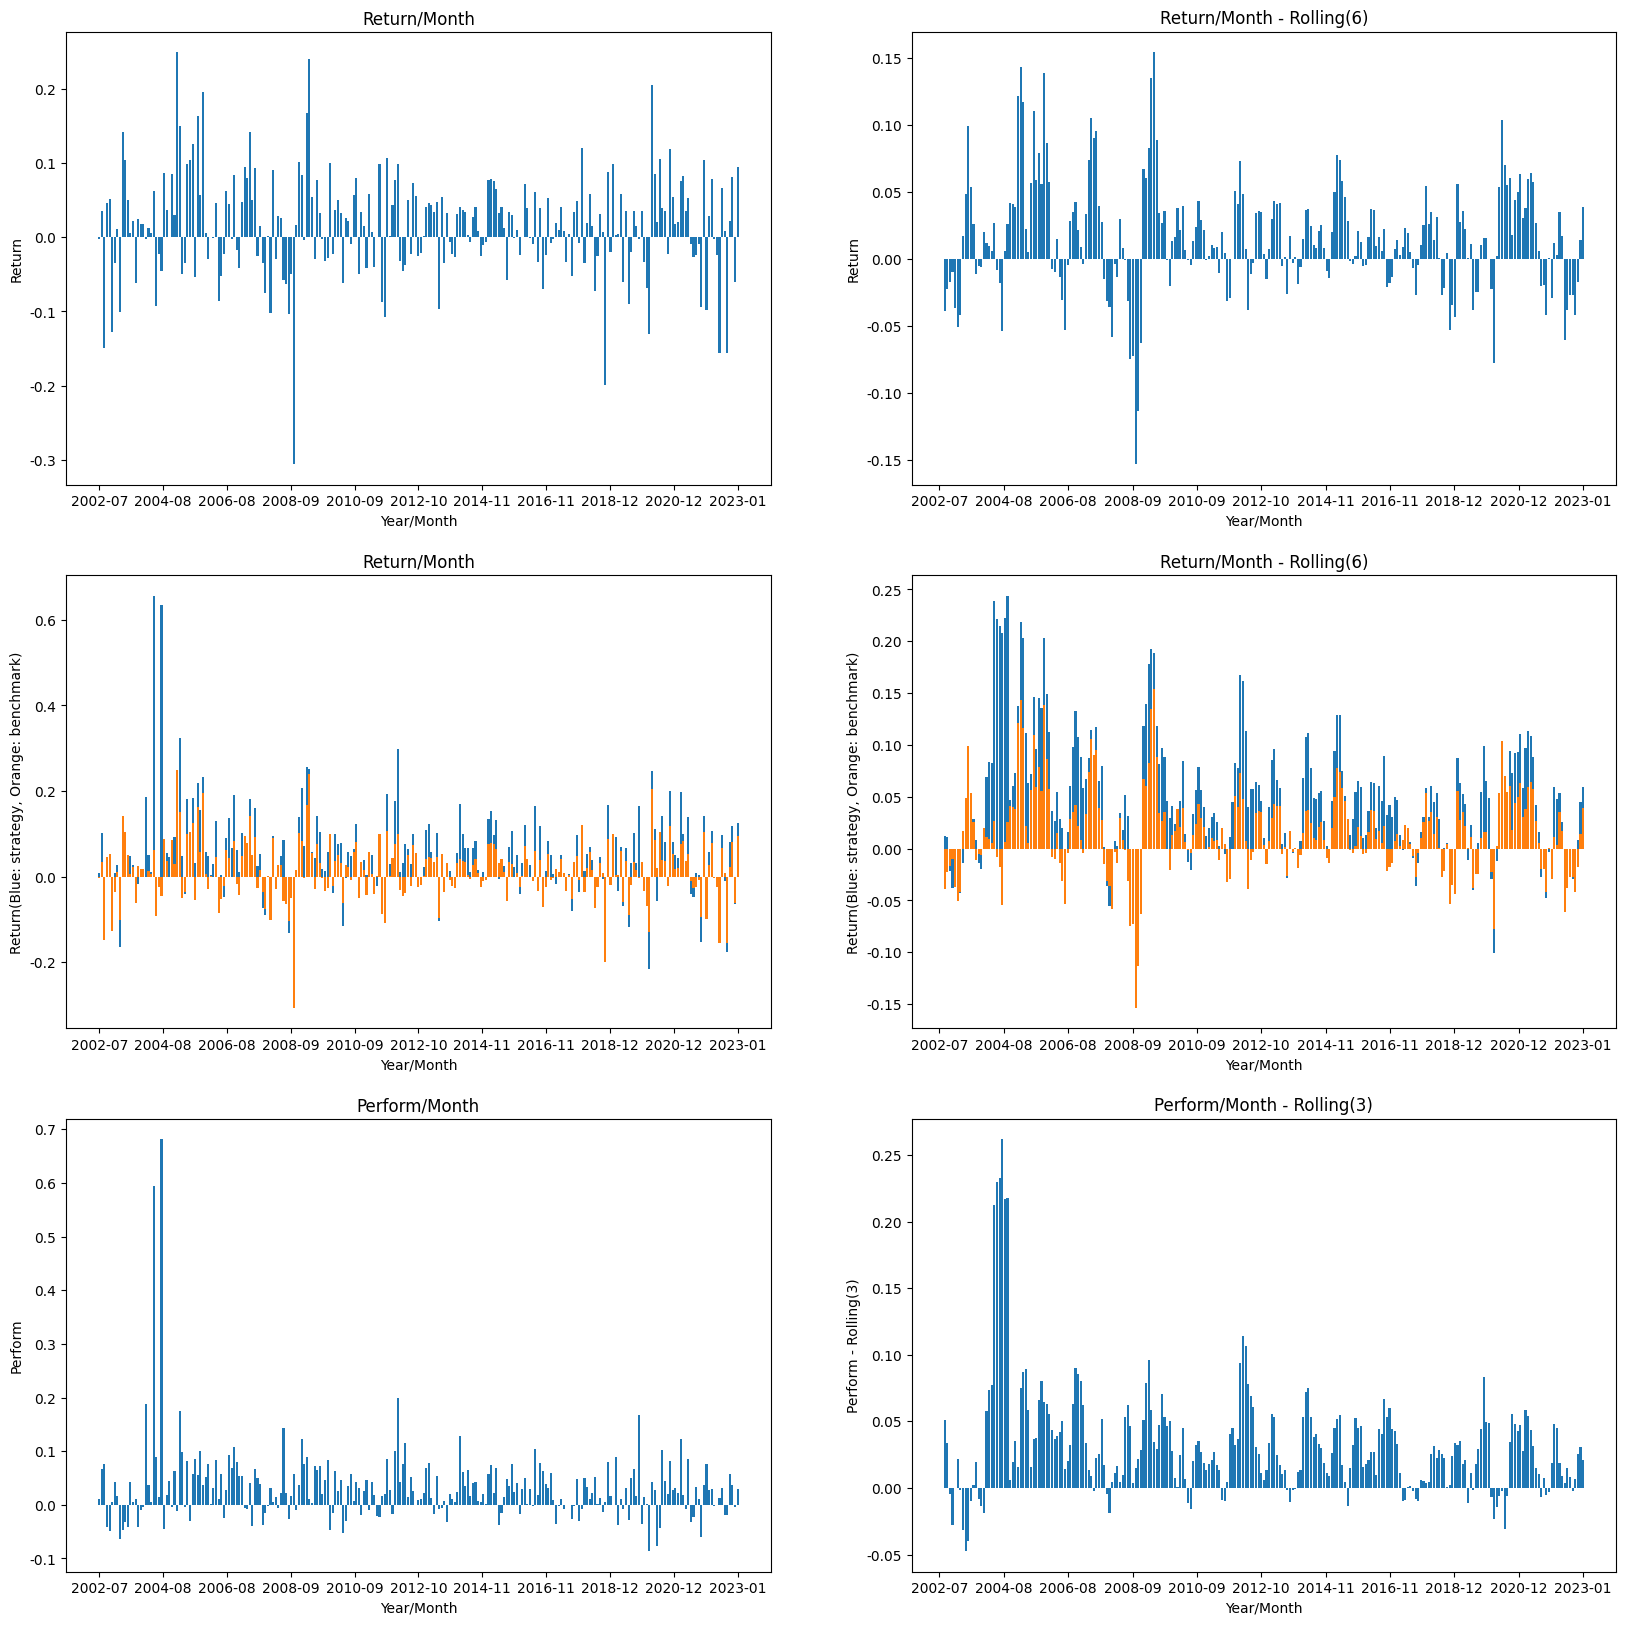

In [11]:
import numpy as np
import matplotlib.pyplot as plt

months = [i for _, i in strategy.index]

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

ax1.set_title(f"Return/Month")
ax1.set_xlabel("Year/Month")
ax1.set_ylabel("Return")
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax1.bar(months, revisions["벤치마크 수익률"])

window = 3
ax2.set_title("Return/Month - Rolling(6)")
ax2.set_xlabel("Year/Month")
ax2.set_ylabel("Return")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(months, revisions["벤치마크 수익률"].rolling(window).mean())

ax3.set_title(f"Return/Month")
ax3.set_xlabel("Year/Month")
ax3.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax3.bar(months, revisions["전략 수익률"])
ax3.bar(months, revisions["벤치마크 수익률"])

ax4.set_title("Return/Month - Rolling(6)")
ax4.set_xlabel("Year/Month")
ax4.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax4.bar(months, revisions["전략 수익률"].rolling(window).mean())
ax4.bar(months, revisions["벤치마크 수익률"].rolling(window).mean())

ax5.set_title("Perform/Month")
ax5.set_xlabel("Year/Month"), ax5.set_ylabel("Perform")
ax5.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax5.bar(months, revisions["전략 수익률"] - revisions["벤치마크 수익률"])

ax6.set_title(f"Perform/Month - Rolling({window})")
ax6.set_xlabel("Year/Month")
ax6.set_ylabel(f"Perform - Rolling({window})")
ax6.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax6.bar(months, (revisions["전략 수익률"] - revisions["벤치마크 수익률"]).rolling(window).mean())

pd.Series({
    "전체 개월 수": len(revisions),
    "초과수익 개월 수": len(revisions[revisions["성능"] > 0]),
    "아웃퍼폼 총합": revisions[revisions["성능"] > 0]["성능"].sum(),
    "언더퍼폼 총합": revisions[revisions["성능"] < 0]["성능"].sum()
})